## Batch 307/309 results (using new sdexp models)
- each state chan has its own NL params in order to make gain/dcinterpretable

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns

In [123]:
db_path = '/auto/users/hellerc/code/nems_db/'

## SELECT BATCH, set ON/OFF octave cutoff

In [124]:
batch = 307
cutoff = 0.5   # octaves from target freq to be considered ON BF

## Preprocess df and calculate unique MI / gain

In [125]:
# load model results data
dMI = pd.read_csv(db_path+'nems_lbhb/pupil_behavior_scripts/d_{}_pup_fil_sdexp_snl.csv'.format(batch), index_col=0)
try:
    dMI['r'] = [np.float(r.strip('[]')) for r in dMI['r'].values]
    dMI['r_se'] = [np.float(r.strip('[]')) for r in dMI['r_se'].values]
except:
    pass

# remove AMT cells
dMI = dMI[~dMI.cellid.str.contains('AMT')]

# get task model params / MI
cols = ['cellid', 'state_chan_alt', 'MI', 'g_amplitude', 'g_base', 'g_kappa', 'g_offset',
                                          'd_amplitude', 'd_base', 'd_kappa', 'd_offset', 'r', 'r_se']
file_merge = dMI[(dMI['state_sig']=='st.pup.fil') & (dMI['state_chan_alt'].str.contains('ACTIVE'))][cols].merge(\
                dMI[(dMI['state_sig']=='st.pup.fil0') & (dMI['state_chan_alt'].str.contains('ACTIVE'))][cols], \
                on=['cellid', 'state_chan_alt'])
def fn_task(a, b, k, o):
    high = b + a * np.exp(-np.exp(-np.exp(k) * (1 - o)))
    lo = b + a * np.exp(-np.exp(-np.exp(k) * (0 - o)))
    return (high - lo) #/ (high + lo)

def fn_pupil(a, b, k, o):
    high = b + a * np.exp(-np.exp(-np.exp(k) * (.5 - o)))
    lo = b + a * np.exp(-np.exp(-np.exp(k) * (-.5 - o)))
    return (high - lo) #/ (high + lo)

    
file_merge['gain_task'] = [fn_task(a, b, k, o) for (a, b, k, o) in 
                                   zip(file_merge['g_amplitude_x'], file_merge['g_base_x'], file_merge['g_kappa_x'], file_merge['g_offset_x'])]
file_merge['MI_task'] = file_merge['MI_x'] - file_merge['MI_y']
file_merge['dc_task'] = [fn_task(a, b, k, o) for (a, b, k, o) in 
                                   zip(file_merge['d_amplitude_x'], file_merge['d_base_x'], file_merge['d_kappa_x'], file_merge['d_offset_x'])]

# get sig task cells
file_merge['sig_task'] = [True if ((file_merge.iloc[i]['r_x'] - file_merge.iloc[i]['r_y']) > 
                                        (file_merge.iloc[i]['r_se_x'] + file_merge.iloc[i]['r_se_y'])) else False for i in range(file_merge.shape[0])]

# strip extraneous columns
file_merge = file_merge.drop(columns=[c for c in file_merge.columns if ('_x' in c) | ('_y' in c)])

# get pupil model params / MI
pupil_merge = dMI[(dMI['state_sig']=='st.pup.fil') & (dMI['state_chan_alt']=='pupil')][cols].merge(\
                dMI[(dMI['state_sig']=='st.pup0.fil') & (dMI['state_chan_alt']=='pupil')][cols], \
                on=['cellid', 'state_chan_alt'])

pupil_merge['gain_pupil'] = [fn_pupil(a, b, k, o) for (a, b, k, o) in 
                                   zip(pupil_merge['g_amplitude_x'], pupil_merge['g_base_x'], pupil_merge['g_kappa_x'], pupil_merge['g_offset_x'])]
pupil_merge['MI_pupil'] = pupil_merge['MI_x'] - pupil_merge['MI_y']
pupil_merge['dc_pupil'] = [fn_pupil(a, b, k, o) for (a, b, k, o) in 
                                   zip(pupil_merge['d_amplitude_x'], pupil_merge['d_base_x'], pupil_merge['d_kappa_x'], pupil_merge['d_offset_x'])]

# get sig pupil cells
pupil_merge['sig_pupil'] = [True if ((pupil_merge.iloc[i]['r_x'] - pupil_merge.iloc[i]['r_y']) > 
                                        (pupil_merge.iloc[i]['r_se_x'] + pupil_merge.iloc[i]['r_se_y'])) else False for i in range(pupil_merge.shape[0])]

# strip extraneous columns
pupil_merge = pupil_merge.drop(columns=[c for c in pupil_merge.columns if ('_x' in c) | ('_y' in c)])
pupil_merge = pupil_merge.drop(columns=['state_chan_alt'])

# load BF / SNR data
dBF = pd.read_csv(db_path+'nems_lbhb/pupil_behavior_scripts/d_{}_tuning.csv'.format(batch), index_col=0)
dBF.index.name = 'cellid'

# load tar frequencies
dTF = pd.read_csv(db_path+'nems_lbhb/pupil_behavior_scripts/d_{}_tar_freqs.csv'.format(batch), index_col=0)

# merge results into single df for 307 and for 309
df = file_merge.merge(dTF, on=['cellid', 'state_chan_alt'])
df = df.merge(pupil_merge, on=['cellid'])
df.index = df.cellid
df = df.drop(columns=['cellid'])

df = df.merge(dBF, left_index=True, right_index=True)

# add column classifying octave sep. from target
df['oct_diff'] = abs(np.log2(df['tar_freq'] / df['BF']))

# add column for on cells / off cells
df['ON_BF'] = [True if df.iloc[i]['oct_diff']<=cutoff else False for i in range(df.shape[0])]
df['OFF_BF'] = [True if df.iloc[i]['oct_diff']>cutoff else False for i in range(df.shape[0])]

In [126]:
df.head()

,state_chan_alt,gain_task,MI_task,dc_task,sig_task,tar_freq,gain_pupil,MI_pupil,dc_pupil,sig_pupil,BF,SNR,oct_diff,ON_BF,OFF_BF
cellid,,,,,,,,,,,,,,,
BRT026c-02-1,ACTIVE_1,-0.550469,-0.131765,-0.225965,True,14000.0,0.161328,0.013721,0.000001,False,29836.0,15.558886,1.091627,False,True
BRT026c-02-1,ACTIVE_2,-0.043282,-0.006990,-0.026749,True,14000.0,0.161328,0.013721,0.000001,False,29836.0,15.558886,1.091627,False,True
BRT026c-02-1,ACTIVE_3,-0.334928,-0.027772,-0.057479,True,14000.0,0.161328,0.013721,0.000001,False,29836.0,15.558886,1.091627,False,True
BRT026c-02-2,ACTIVE_0,0.049419,-0.002945,-0.015986,False,14000.0,0.044540,0.038870,0.048563,False,17041.0,10.292898,0.283583,True,False
BRT026c-02-2,ACTIVE_1,-0.142020,-0.062101,-0.063397,False,14000.0,0.044540,0.038870,0.048563,False,17041.0,10.292898,0.283583,True,False


## Plot behavior results

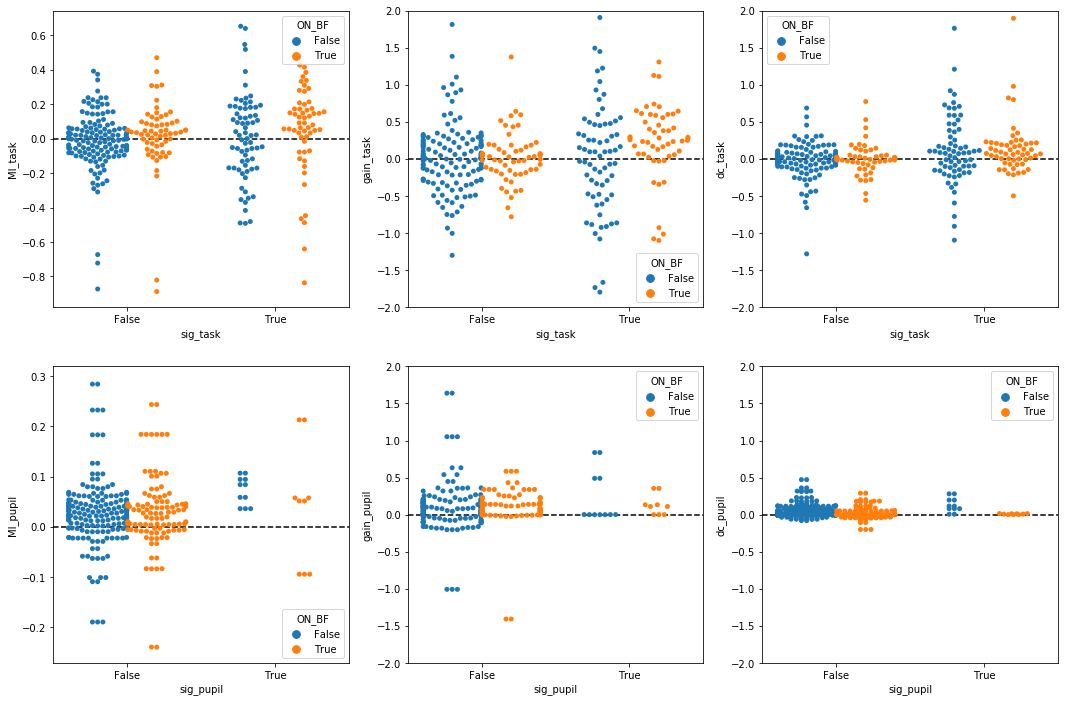

In [127]:
fix_ylims = True

f, ax = plt.subplots(2, 3, figsize=(18, 12))

# BEHAVIOR results
# MI
sns.swarmplot(x='sig_task', y='MI_task', hue='ON_BF', data=df, dodge=True, ax=ax[0, 0])
ax[0, 0].axhline(0, linestyle='--', color='k')

# Gain
sns.swarmplot(x='sig_task', y='gain_task', hue='ON_BF', data=df, dodge=True, ax=ax[0, 1])
ax[0, 1].axhline(0, linestyle='--', color='k')

# DC
sns.swarmplot(x='sig_task', y='dc_task', hue='ON_BF', data=df, dodge=True, ax=ax[0, 2])
ax[0, 2].axhline(0, linestyle='--', color='k')


# PUPIL results
# MI
sns.swarmplot(x='sig_pupil', y='MI_pupil', hue='ON_BF', data=df, dodge=True, ax=ax[1, 0])
ax[1, 0].axhline(0, linestyle='--', color='k')

# Gain
sns.swarmplot(x='sig_pupil', y='gain_pupil', hue='ON_BF', data=df, dodge=True, ax=ax[1, 1])
ax[1, 1].axhline(0, linestyle='--', color='k')

# DC
sns.swarmplot(x='sig_pupil', y='dc_pupil', hue='ON_BF', data=df, dodge=True, ax=ax[1, 2])
ax[1, 2].axhline(0, linestyle='--', color='k')

if fix_ylims:
    for a in [ax[0, 1], ax[0, 2], ax[1, 1], ax[1, 2]]:
        a.set_ylim((-2, 2))

Text(0.5,1,'on: 0.097, off: 0.032, \non_pval: 0.019, off_pval: 0.194')

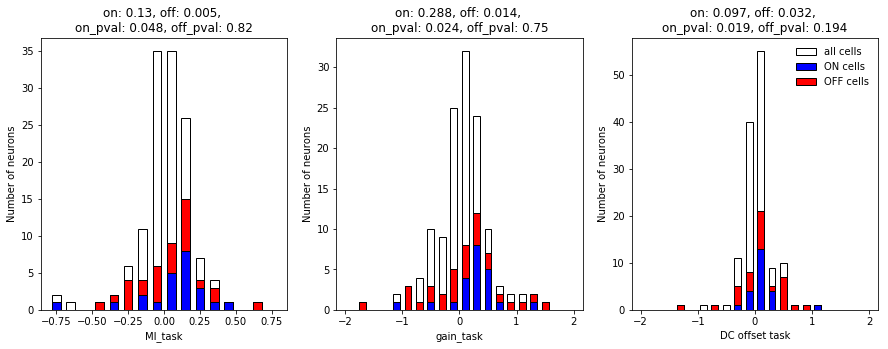

In [128]:
f, ax = plt.subplots(1, 3, figsize=(15, 5))

mi_bins = np.arange(-.8, .9, 0.1)
ax[0].hist(df.groupby(by=['cellid', 'ON_BF']).mean()['MI_task'], 
           bins=mi_bins, color='white', edgecolor='k', rwidth=0.6, label='all cells')
ax[0].hist([df[df['sig_task'] & df['ON_BF']].groupby(by='cellid').mean()['MI_task'], 
            df[df['sig_task'] & df['OFF_BF']].groupby(by='cellid').mean()['MI_task']],
           color=['blue', 'red'], bins=mi_bins, edgecolor='k', rwidth=0.6, 
           label=['ON cells', 'OFF cells'], histtype='barstacked')
ax[0].set_xlabel('MI_task', fontsize=10)
ax[0].set_ylabel('Number of neurons', fontsize=10)


gain_bins = np.arange(-2, 2.2, .2)
ax[1].hist(df.groupby(by=['cellid', 'ON_BF']).mean()['gain_task'], 
           bins=gain_bins, color='white', edgecolor='k', rwidth=0.6, label='all cells')
ax[1].hist([df[df['sig_task'] & df['ON_BF']].groupby(by='cellid').mean()['gain_task'], 
            df[df['sig_task'] & df['OFF_BF']].groupby(by='cellid').mean()['gain_task']],
           color=['blue', 'red'], bins=gain_bins, edgecolor='k', rwidth=0.6, 
           label=['ON cells', 'OFF cells'], histtype='barstacked')
ax[1].set_xlabel('gain_task', fontsize=10)
ax[1].set_ylabel('Number of neurons', fontsize=10)

dc_bins = np.arange(-2, 2.2, .2)
ax[2].hist(df.groupby(by=['cellid', 'ON_BF']).mean()['dc_task'], 
           bins=dc_bins, color='white', edgecolor='k', rwidth=0.6, label='all cells')
ax[2].hist([df[df['sig_task'] & df['ON_BF']].groupby(by='cellid').mean()['dc_task'], 
            df[df['sig_task'] & df['OFF_BF']].groupby(by='cellid').mean()['dc_task']],
           color=['blue', 'red'], bins=dc_bins, edgecolor='k', rwidth=0.6, 
           label=['ON cells', 'OFF cells'], histtype='barstacked')
ax[2].set_xlabel('DC offset task', fontsize=10)
ax[2].set_ylabel('Number of neurons', fontsize=10)
ax[2].legend(frameon=False, fontsize=10)


# add stats

# MI
on_median = np.round(df[df['sig_task'] & df['ON_BF']].groupby(by='cellid').mean()['MI_task'].median(), 3)
on_pval = np.round(ss.wilcoxon(df[df['sig_task'] & df['ON_BF']].groupby(by='cellid').mean()['MI_task']).pvalue, 3)
off_median = np.round(df[df['sig_task'] & df['OFF_BF']].groupby(by='cellid').mean()['MI_task'].median(), 3)
off_pval = np.round(ss.wilcoxon(df[df['sig_task'] & df['OFF_BF']].groupby(by='cellid').mean()['MI_task']).pvalue, 3)
ax[0].set_title('on: {0}, off: {1}, \n'
                'on_pval: {2}, off_pval: {3}'.format(on_median, off_median, on_pval, off_pval))
# gain
on_median = np.round(df[df['sig_task'] & df['ON_BF']].groupby(by='cellid').mean()['gain_task'].median(), 3)
on_pval = np.round(ss.wilcoxon(df[df['sig_task'] & df['ON_BF']].groupby(by='cellid').mean()['gain_task']).pvalue, 3)
off_median = np.round(df[df['sig_task'] & df['OFF_BF']].groupby(by='cellid').mean()['gain_task'].median(), 3)
off_pval = np.round(ss.wilcoxon(df[df['sig_task'] & df['OFF_BF']].groupby(by='cellid').mean()['gain_task']).pvalue, 3)
ax[1].set_title('on: {0}, off: {1}, \n'
                'on_pval: {2}, off_pval: {3}'.format(on_median, off_median, on_pval, off_pval))

# DC
on_median = np.round(df[df['sig_task'] & df['ON_BF']].groupby(by='cellid').mean()['dc_task'].median(), 3)
on_pval = np.round(ss.wilcoxon(df[df['sig_task'] & df['ON_BF']].groupby(by='cellid').mean()['dc_task']).pvalue, 3)
off_median = np.round(df[df['sig_task'] & df['OFF_BF']].groupby(by='cellid').mean()['dc_task'].median(), 3)
off_pval = np.round(ss.wilcoxon(df[df['sig_task'] & df['OFF_BF']].groupby(by='cellid').mean()['dc_task']).pvalue, 3)
ax[2].set_title('on: {0}, off: {1}, \n'
                'on_pval: {2}, off_pval: {3}'.format(on_median, off_median, on_pval, off_pval))

## Plot pupil results

/home/hellerc/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:2385: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
/home/hellerc/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:2385: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
/home/hellerc/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:2385: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
/home/hellerc/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:2385: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
/home/hellerc/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:2385: UserWarning: War

Text(0.5,1,'on: 0.009, off: 0.115, \non_pval: 0.109, off_pval: 0.043')

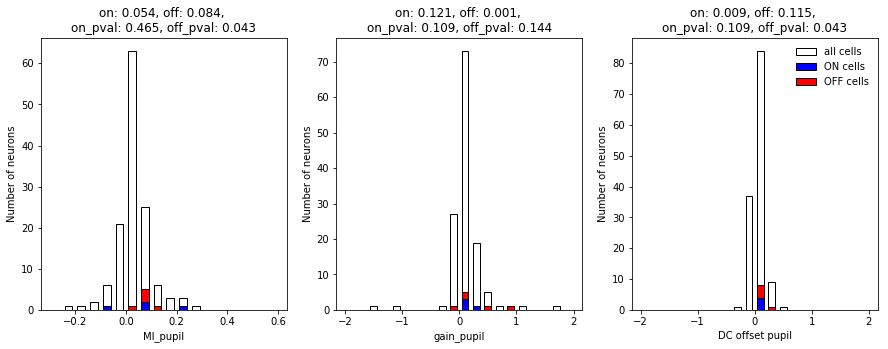

In [129]:
f, ax = plt.subplots(1, 3, figsize=(15, 5))

mi_bins = np.arange(-.3, .65, 0.05)
ax[0].hist(df.groupby(by=['cellid', 'ON_BF']).mean()['MI_pupil'], 
           bins=mi_bins, color='white', edgecolor='k', rwidth=0.6, label='all cells')
ax[0].hist([df[df['sig_pupil'] & df['ON_BF']].groupby(by='cellid').mean()['MI_pupil'], 
            df[df['sig_pupil'] & df['OFF_BF']].groupby(by='cellid').mean()['MI_pupil']],
           color=['blue', 'red'], bins=mi_bins, edgecolor='k', rwidth=0.6, 
           label=['ON cells', 'OFF cells'], histtype='barstacked')
ax[0].set_xlabel('MI_pupil', fontsize=10)
ax[0].set_ylabel('Number of neurons', fontsize=10)

gain_bins = np.arange(-2, 2.2, .2)
ax[1].hist(df.groupby(by=['cellid', 'ON_BF']).mean()['gain_pupil'], 
           bins=gain_bins, color='white', edgecolor='k', rwidth=0.6, label='all cells')
ax[1].hist([df[df['sig_pupil'] & df['ON_BF']].groupby(by='cellid').mean()['gain_pupil'], 
            df[df['sig_pupil'] & df['OFF_BF']].groupby(by='cellid').mean()['gain_pupil']],
           color=['blue', 'red'], bins=gain_bins, edgecolor='k', rwidth=0.6, 
           label=['ON cells', 'OFF cells'], histtype='barstacked')
ax[1].set_xlabel('gain_pupil', fontsize=10)
ax[1].set_ylabel('Number of neurons', fontsize=10)

dc_bins = np.arange(-2, 2.2, .2)
ax[2].hist(df.groupby(by=['cellid', 'ON_BF']).mean()['dc_pupil'], 
           bins=dc_bins, color='white', edgecolor='k', rwidth=0.6, label='all cells')
ax[2].hist([df[df['sig_pupil'] & df['ON_BF']].groupby(by='cellid').mean()['dc_pupil'], 
            df[df['sig_pupil'] & df['OFF_BF']].groupby(by='cellid').mean()['dc_pupil']],
           color=['blue', 'red'], bins=dc_bins, edgecolor='k', rwidth=0.6, 
           label=['ON cells', 'OFF cells'], histtype='barstacked')
ax[2].set_xlabel('DC offset pupil', fontsize=10)
ax[2].set_ylabel('Number of neurons', fontsize=10)
ax[2].legend(frameon=False, fontsize=10)


# add stats

# MI
on_median = np.round(df[df['sig_pupil'] & df['ON_BF']].groupby(by='cellid').mean()['MI_pupil'].median(), 3)
on_pval = np.round(ss.wilcoxon(df[df['sig_pupil'] & df['ON_BF']].groupby(by='cellid').mean()['MI_pupil']).pvalue, 3)
off_median = np.round(df[df['sig_pupil'] & df['OFF_BF']].groupby(by='cellid').mean()['MI_pupil'].median(), 3)
off_pval = np.round(ss.wilcoxon(df[df['sig_pupil'] & df['OFF_BF']].groupby(by='cellid').mean()['MI_pupil']).pvalue, 3)
ax[0].set_title('on: {0}, off: {1}, \n'
                'on_pval: {2}, off_pval: {3}'.format(on_median, off_median, on_pval, off_pval))
# gain
on_median = np.round(df[df['sig_pupil'] & df['ON_BF']].groupby(by='cellid').mean()['gain_pupil'].median(), 3)
on_pval = np.round(ss.wilcoxon(df[df['sig_pupil'] & df['ON_BF']].groupby(by='cellid').mean()['gain_pupil']).pvalue, 3)
off_median = np.round(df[df['sig_pupil'] & df['OFF_BF']].groupby(by='cellid').mean()['gain_pupil'].median(), 3)
off_pval = np.round(ss.wilcoxon(df[df['sig_pupil'] & df['OFF_BF']].groupby(by='cellid').mean()['gain_pupil']).pvalue, 3)
ax[1].set_title('on: {0}, off: {1}, \n'
                'on_pval: {2}, off_pval: {3}'.format(on_median, off_median, on_pval, off_pval))

# DC
on_median = np.round(df[df['sig_pupil'] & df['ON_BF']].groupby(by='cellid').mean()['dc_pupil'].median(), 3)
on_pval = np.round(ss.wilcoxon(df[df['sig_pupil'] & df['ON_BF']].groupby(by='cellid').mean()['dc_pupil']).pvalue, 3)
off_median = np.round(df[df['sig_pupil'] & df['OFF_BF']].groupby(by='cellid').mean()['dc_pupil'].median(), 3)
off_pval = np.round(ss.wilcoxon(df[df['sig_pupil'] & df['OFF_BF']].groupby(by='cellid').mean()['dc_pupil']).pvalue, 3)
ax[2].set_title('on: {0}, off: {1}, \n'
                'on_pval: {2}, off_pval: {3}'.format(on_median, off_median, on_pval, off_pval))

## Compare cells that were recorded for both ON/OFF conditions

In [130]:
on_cells = df[df['ON_BF']].index.unique()
off_cells = df[df['OFF_BF']].index.unique()
matched = np.unique([c for c in df.index.unique() if (c in on_cells.values) & (c in off_cells.values)])
print('{0} cellids found for both condtions'.format(len(matched)))

3 cellids found for both condtions


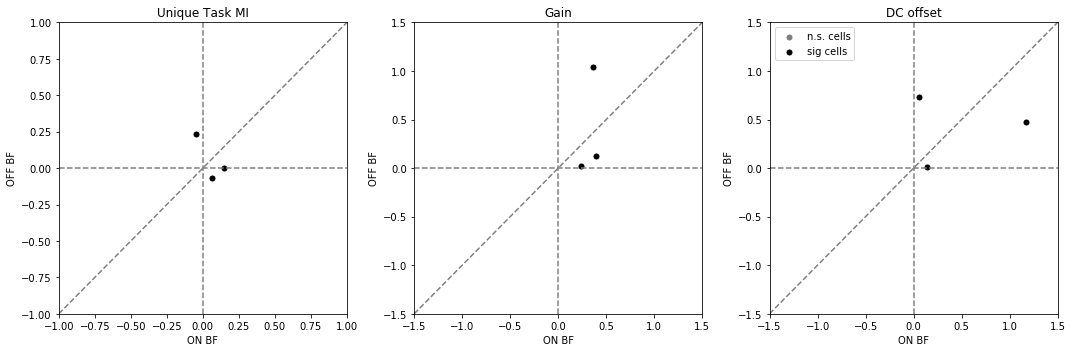

In [131]:
f, ax = plt.subplots(1, 3, figsize=(15, 5))

taskON = df[df.index.isin(matched) & (df.ON_BF)].groupby(by='cellid').mean()
taskOFF = df[df.index.isin(matched) & (df.OFF_BF)].groupby(by='cellid').mean()

ax[0].set_title('Unique Task MI')
ax[0].scatter(taskON['MI_task'], taskOFF['MI_task'], color='grey', edgecolor='white', s=50)
ax[0].scatter(taskON[taskON.sig_task]['MI_task'], 
                taskOFF[taskOFF.sig_task]['MI_task'], color='k', edgecolor='white', s=50)
ax[0].plot([-1, 1], [-1, 1], 'grey', linestyle='--')
ax[0].axhline(0, linestyle='--', color='grey')
ax[0].axvline(0, linestyle='--', color='grey')
ax[0].set_xlim((-1, 1))
ax[0].set_ylim((-1, 1))
ax[0].set_xlabel('ON BF')
ax[0].set_ylabel('OFF BF')

axlim = 1.5
ax[1].set_title('Gain')
ax[1].scatter(taskON['gain_task'], taskOFF['gain_task'], color='grey', edgecolor='white', s=50)
ax[1].scatter(taskON[taskON.sig_task]['gain_task'], 
                taskOFF[taskOFF.sig_task]['gain_task'], color='k', edgecolor='white', s=50)
ax[1].plot([-axlim, axlim], [-axlim, axlim], 'grey', linestyle='--')
ax[1].axhline(0, linestyle='--', color='grey')
ax[1].axvline(0, linestyle='--', color='grey')
ax[1].set_xlim((-axlim, axlim))
ax[1].set_ylim((-axlim, axlim))
ax[1].set_xlabel('ON BF')
ax[1].set_ylabel('OFF BF')

ax[2].set_title('DC offset')
ax[2].scatter(taskON['dc_task'], taskOFF['dc_task'], color='grey', edgecolor='white', s=50, label='n.s. cells')
ax[2].scatter(taskON[taskON.sig_task]['dc_task'], 
                taskOFF[taskOFF.sig_task]['dc_task'], color='k', edgecolor='white', s=50, label='sig cells')
ax[2].plot([-axlim, axlim], [-axlim, axlim], 'grey', linestyle='--')
ax[2].axhline(0, linestyle='--', color='grey')
ax[2].axvline(0, linestyle='--', color='grey')
ax[2].legend()
ax[2].set_xlim((-axlim, axlim))
ax[2].set_ylim((-axlim, axlim))
ax[2].set_xlabel('ON BF')
ax[2].set_ylabel('OFF BF')

f.tight_layout()